In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import scipy.stats as stats
%matplotlib inline

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [6]:
df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


# Missing values

In [7]:
# percentage of missing values in every column
df.isnull().sum()/df.isnull().count()

date                   0.0
summary                0.0
preciptype             0.0
temperature            0.0
apparenttemperature    0.0
humidity               0.0
windspeed              0.0
windbearing            0.0
visibility             0.0
loudcover              0.0
pressure               0.0
dailysummary           0.0
dtype: float64

There are no missing values

In [8]:
nonsense = df[df['pressure'] < 200].index
df.drop(index=nonsense, inplace=True)

# Distribution of explanatory and target variables

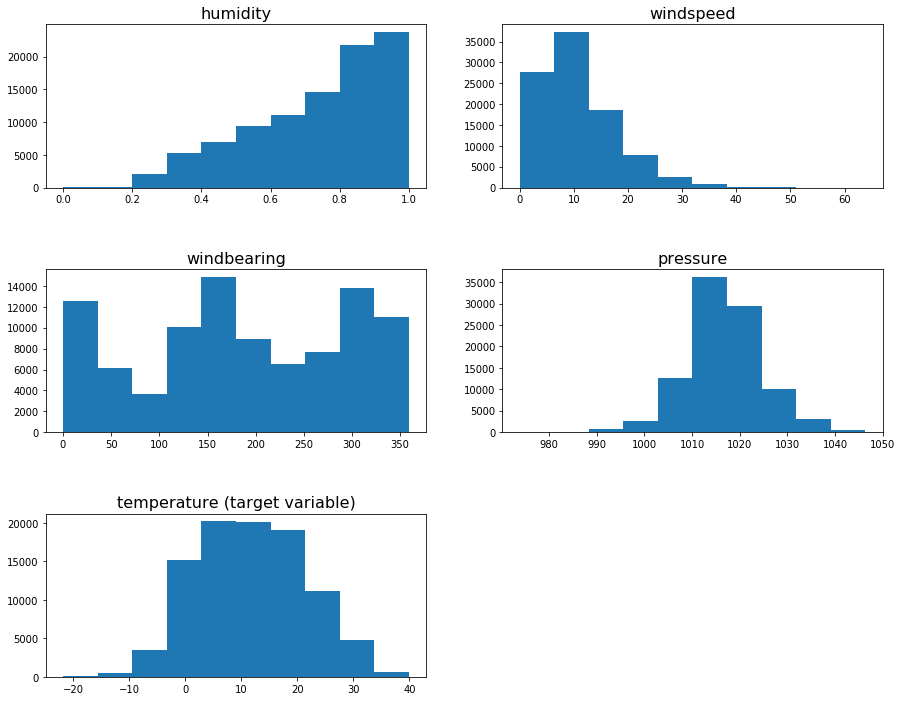

In [9]:
target = df['temperature']
explanatory_var = ['humidity', 'windspeed', 'windbearing', 'pressure']

plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=.5)

i = 1
for col in explanatory_var:
    plt.subplot(3, 2, i)
    plt.hist(df[col])
    plt.title(col, fontsize=16)
    i += 1

plt.subplot(3, 2, 5)
plt.hist(df['temperature'])
plt.title('temperature (target variable)', fontsize=16)
plt.show()

Our target variable 'temperature' may be normally distrubuted, but all of the other explanatory variables show non-normal distribution.

# Linear regression model (OLS)

In [10]:
X = df[explanatory_var]
Y = target

from sklearn import linear_model

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nY intercept: \n', lrm.intercept_)


Coefficients: 
 [-3.27467869e+01 -3.17826353e-01  2.52552064e-03 -4.17393403e-01]

Y intercept: 
 463.38270827696647


Temperature = 37.93 - 32.50 (humidity) - 0.201 (windspeed) + 0.004 (windbearing) - .0007 (pressure)

# Now, let's check if our model meets the Gauss-Markov Conditions.

### Assumption one: linearity of the model in its coefficients

I took into account this assumption when designing my model, and this condition is met.

### Assumption two: the error term should be zero on average

In [11]:
predictions = lrm.predict(X)
errors = Y - predictions

print("The average error for this temperature mode is: {}".format(np.mean(errors)))

The average error for this temperature mode is: 1.1226101106754754e-13


The average error is effectively zero, so this condition has been met.

### Assumption three: homoscedasticity

In [12]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 313.458 and p value is 3.85e-70
Levene test statistic value is 235.663 and p value is 3.74e-53


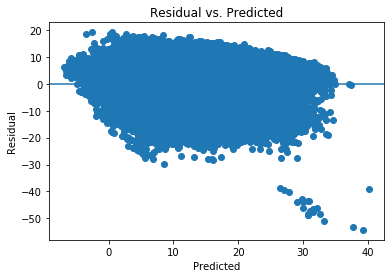

In [13]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Based on the Bartlett and Levene test. The errors in our model are not homscedastic. This is most likely due to the outliers in our pressure variable or prossibly not including a relevant variable in our model.

### Assumption four: low multicollinearity

In [14]:
df[explanatory_var].corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224282,0.001598,0.039257
windspeed,-0.224282,1.000000,0.101633,-0.253700
windbearing,0.001598,0.101633,1.000000,-0.078687
pressure,0.039257,-0.253700,-0.078687,1.000000


All of the explanatory variable show slight to no correlation with each other. This condition has been met.

### Assumption five: error terms should be uncorrelated with one another

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


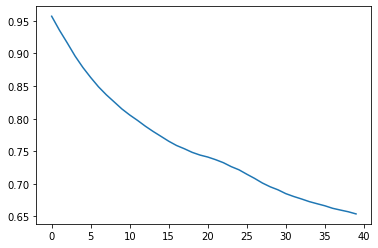

In [15]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

This condition has not been met. The errors have a correlation between .70 and .95.

### Assumption six: features shouldn't be correlated with the errors

In [16]:
df['errors'] = errors
df[explanatory_var + ['errors']].corr()

,humidity,windspeed,windbearing,pressure,errors
humidity,1.000000e+00,-2.242816e-01,1.597885e-03,3.925713e-02,3.241394e-15
windspeed,-2.242816e-01,1.000000e+00,1.016334e-01,-2.536997e-01,1.408100e-17
windbearing,1.597885e-03,1.016334e-01,1.000000e+00,-7.868736e-02,1.281908e-16
pressure,3.925713e-02,-2.536997e-01,-7.868736e-02,1.000000e+00,1.237161e-16
errors,3.241394e-15,1.408100e-17,1.281908e-16,1.237161e-16,1.000000e+00


# House price model

In [17]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [18]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# Feature selection
All of the model features were chosen in a previous exercise

In [19]:
# List of continuous variables for our model
continuous_features = ['overallqual', 'grlivarea', 'garagecars', 'firstflrsf', 'fullbath', 'yearbuilt', 'yearremodadd']

# New Data frame with only features for our model
model_df = pd.DataFrame()
for col in continuous_features:
    model_df[col] = df[col]

# List of categorical features
categorical_features = ['neighborhood', 'exterqual', 'kitchenqual', 'garagefinish', 'bsmtqual']

# Adding the categorical features and target variable to our model DataFrame
model_df = pd.concat([model_df, pd.get_dummies(df[['neighborhood', 'exterqual', 'kitchenqual', 'garagefinish', 'bsmtqual']], drop_first=True), df['saleprice']], axis=1)

In [26]:
X = model_df[['overallqual', 'grlivarea', 'garagecars', 'firstflrsf', 'fullbath',
              'yearbuilt', 'yearremodadd', 'neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide',
              'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards',
              'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel',
              'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge',
              'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer',
              'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber',
              'neighborhood_Veenker', 'exterqual_Fa', 'exterqual_Gd', 'exterqual_TA', 'kitchenqual_Fa',
              'kitchenqual_Gd', 'kitchenqual_TA', 'garagefinish_RFn', 'garagefinish_Unf', 'bsmtqual_Fa',
              'bsmtqual_Gd', 'bsmtqual_TA']]

Y = model_df['saleprice']

from sklearn import linear_model

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

print('Coefficients:\n{}'.format(lrm.coef_))
print('')
print('Y intercept: {}'.format(lrm.intercept_))

Coefficients:
[ 1.26976574e+04  4.23947370e+01  1.30268189e+04  1.80815725e+01
 -2.24287966e+03  1.64077174e+02  2.04164153e+02 -5.78332645e+03
 -7.75974313e+03  1.72270873e+04  4.32754898e+04  2.61592073e+04
  4.49631076e+04  2.01568356e+03  1.69301557e+04  4.09504040e+03
  3.15591801e+03  1.19207039e+04  1.41136882e+04  9.02761178e+03
  1.56073899e+04  8.40408473e+04  5.18966048e+04  1.48282578e+02
  6.78145445e+03  1.49035334e+04  2.00668322e+04  2.89263132e+04
  6.85757778e+04  3.42012428e+04  5.61824728e+04 -3.29535866e+04
 -2.88967776e+04 -2.75724539e+04 -3.71831055e+04 -2.91795555e+04
 -3.50542084e+04 -6.52183179e+03 -1.02625825e+04 -1.13019166e+04
 -1.57101036e+04 -8.55664602e+03]

Y intercept: -676952.7531609697


# Now, let's check if our model meets the Gauss-Markov Conditions.

### Assumption one: linearity of the model in its coefficients

I took into account this assumption when designing my model, and this condition is met.

### Assumption two: the error term should be zero on average

In [27]:
predictions = lrm.predict(X)
errors = Y - predictions

print("The average error for this temperature mode is: {}".format(np.mean(errors)))

The average error for this temperature mode is: 3.1097243501715466e-11


The average error is effectively zero, so this condition has been met.

### Assumption three: homoscedasticity

In [28]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 863.675 and p value is 7.74e-190
Levene test statistic value is 586.008 and p value is 3.94e-118


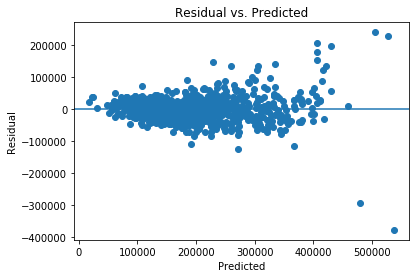

In [29]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Based on the Bartlett and Levene test. The errors in our model are not homscedastic. This is most likely due to the outliers.

### Assumption four: low multicollinearity

In [30]:
model_df[continuous_features].corr()

,overallqual,grlivarea,garagecars,firstflrsf,fullbath,yearbuilt,yearremodadd
overallqual,1.000000,0.593007,0.600671,0.476224,0.550600,0.572323,0.550684
grlivarea,0.593007,1.000000,0.467247,0.566024,0.630012,0.199010,0.287389
garagecars,0.600671,0.467247,1.000000,0.439317,0.469672,0.537850,0.420622
firstflrsf,0.476224,0.566024,0.439317,1.000000,0.380637,0.281986,0.240379
fullbath,0.550600,0.630012,0.469672,0.380637,1.000000,0.468271,0.439046
yearbuilt,0.572323,0.199010,0.537850,0.281986,0.468271,1.000000,0.592855
yearremodadd,0.550684,0.287389,0.420622,0.240379,0.439046,0.592855,1.000000


All of the features show moderate correlation with each other. This condition has not been met. This can be fixed using PCA or dropping features.

### Assumption five: error terms should be uncorrelated with one another

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


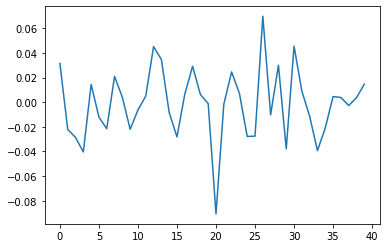

In [31]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The correlation between erros is very low. This condition has been met.

### Assumption six: features shouldn't be correlated with the errors

In [33]:
model_df['errors'] = errors
model_df[continuous_features + ['errors']].corr()

,overallqual,grlivarea,garagecars,firstflrsf,fullbath,yearbuilt,yearremodadd,errors
overallqual,1.000000e+00,5.930074e-01,6.006707e-01,4.762238e-01,5.505997e-01,5.723228e-01,5.506839e-01,1.888033e-15
grlivarea,5.930074e-01,1.000000e+00,4.672474e-01,5.660240e-01,6.300116e-01,1.990097e-01,2.873885e-01,-3.315518e-15
garagecars,6.006707e-01,4.672474e-01,1.000000e+00,4.393168e-01,4.696720e-01,5.378501e-01,4.206222e-01,1.595943e-14
firstflrsf,4.762238e-01,5.660240e-01,4.393168e-01,1.000000e+00,3.806375e-01,2.819859e-01,2.403793e-01,4.318881e-15
fullbath,5.505997e-01,6.300116e-01,4.696720e-01,3.806375e-01,1.000000e+00,4.682708e-01,4.390465e-01,1.828750e-14
yearbuilt,5.723228e-01,1.990097e-01,5.378501e-01,2.819859e-01,4.682708e-01,1.000000e+00,5.928550e-01,-2.890825e-15
yearremodadd,5.506839e-01,2.873885e-01,4.206222e-01,2.403793e-01,4.390465e-01,5.928550e-01,1.000000e+00,1.951133e-14
errors,1.888033e-15,-3.315518e-15,1.595943e-14,4.318881e-15,1.828750e-14,-2.890825e-15,1.951133e-14,1.000000e+00


This condition has been met.